In [2]:
!pip install xgboost

In [4]:
import xgboost as xgb
print(xgb.__version__)

3.0.3



--- Metrics on TEST ---
[XGB (numeric-only, 72→24, holidays+lags+fourier)] MAE: 74.64 | RMSE: 99.51 | MAPE: 15.98% | R²: 0.7688 | Accuracy: 84.02%


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


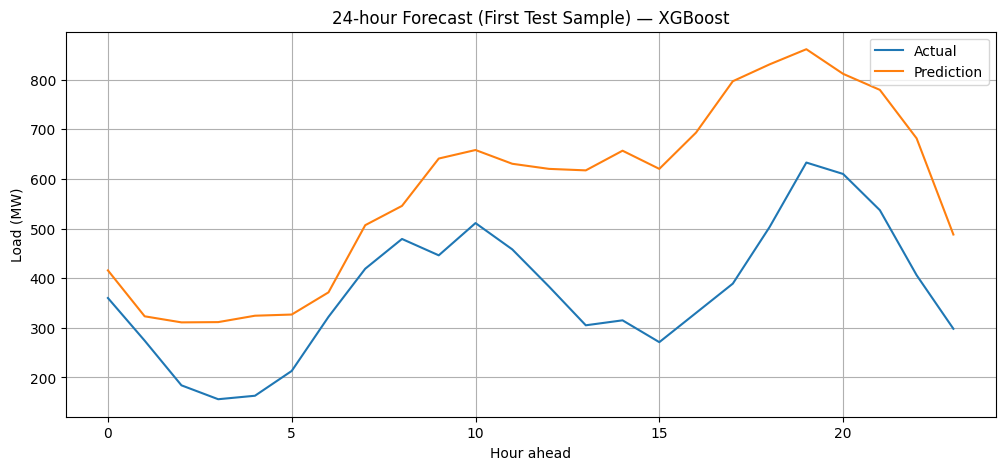

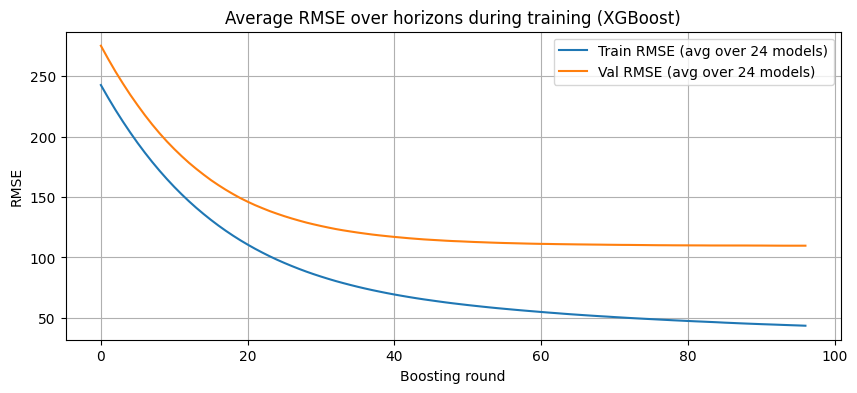

In [5]:
# ========================== Setup & Imports ==========================
import sys, subprocess, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure required packages
def _ensure(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
_ensure("xgboost")
try:
    import holidays
    HAVE_HOLS = True
except Exception:
    HAVE_HOLS = False

import xgboost as xgb
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    mean_absolute_percentage_error, r2_score
)

np.random.seed(42)

# ========================== 1) Load & clean ==========================
df = pd.read_csv("ost_data1.csv", sep=';', engine='python')
df.columns = df.columns.str.strip()

# Fix 'Ora' -> only digits, 2 chars
df['Ora'] = (
    df['Ora'].astype(str)
             .str.extract(r'(\d+)', expand=False)
             .fillna('0')
             .astype(int).astype(str).str.zfill(2)
)

# Parse date
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# Handle possible '24' hour by rolling to next day at 00
mask_24 = df['Ora'] == '24'
df.loc[mask_24, 'Ora']  = '00'
df.loc[mask_24, 'Data'] = df.loc[mask_24, 'Data'] + pd.Timedelta(days=1)

# Build Datetime index
df['Datetime'] = pd.to_datetime(
    df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'],
    format='%Y-%m-%d %H', errors='coerce'
)
df.set_index('Datetime', inplace=True)
df.dropna(how='any', inplace=True)

# Standardize target name
if 'Ngarkesa Totale' in df.columns and 'Load' not in df.columns:
    df = df.rename(columns={'Ngarkesa Totale': 'Load'})

# Build total cross-border exchange if missing
if 'Shkembimi fizik nderkufitar' not in df.columns:
    for c in ['Shkembimi fizik nderkufitar AL-ME',
              'Shkembimi fizik nderkufitar AL-KS',
              'Shkembimi fizik nderkufitar AL-GR']:
        if c not in df.columns:
            df[c] = 0.0
    df['Shkembimi fizik nderkufitar'] = (
        df.get('Shkembimi fizik nderkufitar AL-ME', 0.0) +
        df.get('Shkembimi fizik nderkufitar AL-KS', 0.0) +
        df.get('Shkembimi fizik nderkufitar AL-GR', 0.0)
    )

# Keep a minimal base set if available
base_cols = ['Load', 'Prodhimi Total', 'Shkembimi fizik nderkufitar',
             'Shkembimi fizik nderkufitar AL-ME',
             'Shkembimi fizik nderkufitar AL-KS',
             'Shkembimi fizik nderkufitar AL-GR']
present = [c for c in base_cols if c in df.columns]
df = df[present].copy()

# Basic positivity filter for target if needed
df = df[df['Load'] > 0].copy()

# ========================== 2) Time features & holidays ==========================
df['hour']      = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
df['month']     = df.index.month

# country holidays (AL, ME, XK, GR, union ANY) — optional if holidays available
if HAVE_HOLS:
    years = sorted(df.index.year.unique())
    dser  = pd.Series(df.index.date, index=df.index)

    def _flag(code, fallback=None):
        try:
            cal = holidays.CountryHoliday(code, years=years)
            return dser.isin(cal).astype(int)
        except Exception:
            if fallback is not None:
                try:
                    cal = fallback(years=years)
                    return dser.isin(cal).astype(int)
                except Exception:
                    return pd.Series(0, index=df.index, dtype=int)
            return pd.Series(0, index=df.index, dtype=int)

    df['Holiday_AL'] = _flag('AL')
    df['Holiday_ME'] = _flag('ME')
    # Kosovo can be tricky in some versions
    try:
        df['Holiday_XK'] = _flag('XK', fallback=getattr(holidays, 'Kosovo', None))
    except Exception:
        df['Holiday_XK'] = 0
    df['Holiday_GR'] = _flag('GR')
    df['Holiday_ANY'] = df[['Holiday_AL','Holiday_ME','Holiday_XK','Holiday_GR']].max(axis=1).astype(int)
else:
    # If 'holidays' not available, just put zeros
    for c in ['Holiday_AL','Holiday_ME','Holiday_XK','Holiday_GR','Holiday_ANY']:
        df[c] = 0

# ========================== 3) Lags, rolling, dynamics, Fourier ==========================
df['lag_1']   = df['Load'].shift(1)
df['lag_24']  = df['Load'].shift(24)
df['lag_48']  = df['Load'].shift(48)
df['lag_168'] = df['Load'].shift(168)

df['roll_mean_24'] = df['Load'].rolling(24).mean()
df['roll_std_24']  = df['Load'].rolling(24).std()
df['roll_max_24']  = df['Load'].rolling(24).max()
df['roll_min_24']  = df['Load'].rolling(24).min()

# Exchange dynamics
ex_cols = [c for c in ['Shkembimi fizik nderkufitar',
                       'Shkembimi fizik nderkufitar AL-ME',
                       'Shkembimi fizik nderkufitar AL-KS',
                       'Shkembimi fizik nderkufitar AL-GR'] if c in df.columns]
df['Total_Exchange'] = df[ex_cols].sum(axis=1) if ex_cols else 0.0
df['Delta_Exchange'] = df['Total_Exchange'].diff()

# Fourier seasonality (daily & weekly)
def add_fourier(frame, tag, period, K=3):
    t = np.arange(len(frame), dtype=float)
    for k in range(1, K+1):
        frame[f'{tag}_sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        frame[f'{tag}_cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return frame

df = add_fourier(df, 'fourier_daily', 24,  K=3)
df = add_fourier(df, 'fourier_weekly', 168, K=3)

# Drop NaNs created by lags/rolling
df.dropna(inplace=True)

# ========================== 4) Keep ONLY numeric columns ==========================
if 'Load' not in df.columns:
    raise ValueError("'Load' column not found after preprocessing.")

# Drop any non-numeric column (e.g., datetimes/strings)
non_numeric = df.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    df = df.drop(columns=non_numeric)

# Enforce Load numeric & valid
df['Load'] = pd.to_numeric(df['Load'], errors='coerce')
df = df.dropna(subset=['Load'])

# ========================== 5) Windowing 72 → 24 ==========================
def make_windows(frame, input_window=72, output_horizon=24, target='Load'):
    X, y, times = [], [], []
    cols = frame.columns.tolist()
    t_idx = cols.index(target)
    idx = frame.index

    for i in range(input_window, len(frame) - output_horizon):
        past   = frame.iloc[i-input_window:i].values        # (72, F)
        future = frame.iloc[i:i+output_horizon, t_idx].values  # (24,)
        X.append(past)
        y.append(future)
        times.append(idx[i:i+output_horizon].values)  # timestamps per horizon
    return np.array(X), np.array(y), np.array(times)

X_all, y_all, times_all = make_windows(df, 72, 24, target='Load')

# Cast to float32 for XGBoost compatibility
X_all = X_all.astype(np.float32)
y_all = y_all.astype(np.float32)

# Flatten the 3D past window into 2D features (N, 72*F)
N, Win, F = X_all.shape
X_all = X_all.reshape(N, Win*F)

# ========================== 6) Time split: 70/10/20 ==========================
n_total = X_all.shape[0]
i_train_end = int(n_total * 0.70)
i_val_end   = int(n_total * 0.80)

X_train, X_val, X_test = X_all[:i_train_end], X_all[i_train_end:i_val_end], X_all[i_val_end:]
y_train, y_val, y_test = y_all[:i_train_end], y_all[i_train_end:i_val_end], y_all[i_val_end:]
times_train, times_val, times_test = times_all[:i_train_end], times_all[i_train_end:i_val_end], times_all[i_val_end:]

# ========================== 7) XGBoost (one model per horizon) ==========================
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'min_child_weight': 1,
    'tree_method': 'hist',
    'seed': 42,
}
num_boost_round = 200
early_stopping_rounds = 20

models = []
eval_histories = []  # for optional plotting later

for h in range(y_train.shape[1]):  # 24 horizons
    dtrain = xgb.DMatrix(X_train, label=y_train[:, h])
    dval   = xgb.DMatrix(X_val,   label=y_val[:, h])

    evals_result = {}
    booster = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result,
        verbose_eval=False
    )
    models.append(booster)
    eval_histories.append(evals_result)

# ========================== 8) Predict on TEST ==========================
dtest = xgb.DMatrix(X_test)
y_pred = np.column_stack([m.predict(dtest, iteration_range=(0, m.best_iteration+1))
                          for m in models])

# ========================== 9) Metrics ==========================
def eval_metrics(y_true_2d, y_pred_2d, tag="XGB 72→24"):
    yt = y_true_2d.reshape(-1)
    yp = y_pred_2d.reshape(-1)
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    eps  = 1e-6
    yt_safe = np.where(yt == 0, eps, yt)
    mape = mean_absolute_percentage_error(yt_safe, yp) * 100
    r2   = r2_score(yt, yp)
    acc  = 100 - mape
    print(f"[{tag}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
    return mae, rmse, mape, r2, acc

print("\n--- Metrics on TEST ---")
eval_metrics(y_test, y_pred, tag="XGB (numeric-only, 72→24, holidays+lags+fourier)")

# ========================== 10) Plot first test sample ==========================
plt.figure(figsize=(12,5))
plt.plot(y_test[0], label='Actual')
plt.plot(y_pred[0], label='Prediction')
plt.title('24-hour Forecast (First Test Sample) — XGBoost')
plt.xlabel('Hour ahead'); plt.ylabel('Load (MW)')
plt.grid(True); plt.legend()
plt.savefig("xgb_forecast_first_sample.png", dpi=600, bbox_inches='tight')
plt.show()

# Average validation loss across horizons

try:
    min_len = min(len(hist['val']['rmse']) for hist in eval_histories)
    avg_val = np.mean([hist['val']['rmse'][:min_len] for hist in eval_histories], axis=0)
    avg_tr  = np.mean([hist['train']['rmse'][:min_len] for hist in eval_histories], axis=0)
    plt.figure(figsize=(10,4))
    plt.plot(avg_tr, label='Train RMSE (avg over 24 models)')
    plt.plot(avg_val, label='Val RMSE (avg over 24 models)')
    plt.title('Average RMSE over horizons during training (XGBoost)')
    plt.xlabel('Boosting round'); plt.ylabel('RMSE'); plt.grid(True); plt.legend()
    plt.savefig("xgb_avg_rmse_train_val.png", dpi=600, bbox_inches='tight')
    plt.show()
except Exception:
    pass
